In [37]:
# Imports

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
path ="/content/drive/MyDrive/2025-2/Machine Learning/proyecto1/"
train_df = pd.read_csv(path + "datos_entrenamiento_riesgo.csv")
test_df = pd.read_csv(path +  "datos_prueba_riesgo.csv")

In [39]:
# EDA
def impute_variables(train_df, test_df):
    categorical_encoded = ['sector_laboral', 'tipo_vivienda', 'nivel_educativo', 'estado_civil']
    for col in categorical_encoded:
        mode_train = train_df[col].mode()[0]
        train_df[col].fillna(mode_train, inplace=True)
        test_df[col].fillna(mode_train, inplace=True)

    numerical = ['porcentaje_utilizacion_credito', 'proporcion_pagos_a_tiempo',
                'residencia_antiguedad_meses', 'lineas_credito_abiertas']
    for col in numerical:
        median_train = train_df[col].median()
        train_df[col].fillna(median_train, inplace=True)
        test_df[col].fillna(median_train, inplace=True)
    return train_df, test_df

def normalize(x_train, x_test):
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

def add_bias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

def encode_labels(y):
    label_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}
    return y.map(label_map).values

# Preparar datasets con imputación
train_imputed, test_imputed = impute_variables(train_df.copy(), test_df.copy())

# Separar features y targets
X_train_imputed = train_imputed.drop('nivel_riesgo', axis=1)
X_test_imputed = test_imputed.drop('nivel_riesgo', axis=1)
y_train_imputed = train_imputed['nivel_riesgo']
y_test_imputed = test_imputed['nivel_riesgo']

# Normalize
X_train_norm, X_test_norm = normalize(X_train_imputed, X_test_imputed)

# Agregar Bias
X_train = add_bias(X_train_norm)
X_test = add_bias(X_test_norm)

# Convertir etiquetas
y_train = encode_labels(y_train_imputed)
y_test = encode_labels(y_test_imputed)

/tmp/ipython-input-3658520347.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_train, inplace=True)
/tmp/ipython-input-3658520347.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [40]:
# Modelo
def h(x,w):
  return np.dot(x, w)

def s(x,w):
  return 1/ (1 + np.exp(-h(x, w)))

def Loss_function(x, y, w):
  epsilon = 1e-15
  n = x.shape[0]
  sum = np.sum(y * np.log(s(x, w) + epsilon)  +
                 (1 - y) * np.log(epsilon + 1 - s(x, w)))
  return (-1/n) * sum

def Derivatives(x,y,w):
  sum = np.dot(-x.T,y - (s(x,w)))
  n = x.shape[0]
  return (1/n) * sum

def change_parameters(w, derivatives, alpha):
  return w - alpha * derivatives

def training(x_train,y_train, epochs, alpha, x_test, y_test):
  print(len(x_train))
  w_train=np.ones(x_train.shape[1])
  LossTrain = []
  LossTest = []
  for i in range(epochs):
    L_Train =  Loss_function(x_train,y_train,w_train)
    L_Test = Loss_function(x_test, y_test, w_train)
    dw = Derivatives(x_train,y_train,w_train)
    w_train =  change_parameters(w_train, dw, alpha)
    if i % 100 == 0:
      print("L_Train:", L_Train)
    LossTrain.append(L_Train)
    LossTest.append(L_Test)
  return w_train,LossTrain, LossTest

def Testing(x_test, y_test,w):
   y_pred = s(x_test,w)
   y_pred = np.round(y_pred)
   correctos = np.sum(y_pred == y_test)
   print(f"Número de datos correctos:{correctos}")
   porc_aciertos= (correctos/len(y_test))*100
   print(f"Porcentaje de aciertos:{porc_aciertos}%")
   print(f"Porcentaje de error:{100-porc_aciertos}%")

def one_vs_all_training(X_train, y_train, X_test, y_test, epochs, alpha):
    models = {}
    class_names = ['Bajo', 'Medio', 'Alto']

    for i, class_name in enumerate(class_names):
        print(f"\n--- Entrenando modelo {class_name} vs Resto ---")

        y_binary = (y_train == i).astype(int)
        y_test_binary = (y_test == i).astype(int)

        print(f"Distribución {class_name}: {np.sum(y_binary)}/{len(y_binary)}")

        # Entrenar modelo binario
        w_model, loss_train, loss_test = training(
            X_train, y_binary, epochs, alpha, X_test, y_test_binary
        )

        models[i] = w_model

    return models

def predict_one_vs_all(X_test, models):
    n_samples = X_test.shape[0]
    n_classes = len(models)

    probabilities = np.zeros((n_samples, n_classes))

    for i, w_model in models.items():
        probabilities[:, i] = s(X_test, w_model)

    y_pred = np.argmax(probabilities, axis=1)

    return y_pred, probabilities

In [41]:
# Matriz de confusión
def analyze_results(y_true, y_pred, title="Matriz de Confusión"):
  cm = confusion_matrix(y_true, y_pred)
  class_names = ['Bajo', 'Medio', 'Alto']

  cm_decimal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm_decimal, annot=True, fmt='.3f', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names, cbar=False)

  plt.title(title)
  plt.tight_layout()
  filename = f'{title.replace(" ", "_").replace("-", "_")}_decimal.png'
  plt.show()

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


--- Entrenando modelo Bajo vs Resto ---
Distribución Bajo: 5968/20000
20000
L_Train: 2.897228243617483
L_Train: 0.1124709153290436
L_Train: 0.08947851320367947
L_Train: 0.07814294272955596
L_Train: 0.07095773140209136
L_Train: 0.06583470473309735
L_Train: 0.061921143021518674
L_Train: 0.05879237569686081
L_Train: 0.05620893339416765
L_Train: 0.05402368026160909
L_Train: 0.0521403249034828
L_Train: 0.0504927228083516
L_Train: 0.04903365887907632
L_Train: 0.047728361191661704
L_Train: 0.046550549867907555
L_Train: 0.045479924738854524
L_Train: 0.0445005093764616
L_Train: 0.0435995256687216
L_Train: 0.04276660852324748
L_Train: 0.04199324517365211
L_Train: 0.04127236668547645
L_Train: 0.04059804497522734
L_Train: 0.03996526447238816
L_Train: 0.039369747550496964
L_Train: 0.038807819326793114
L_Train: 0.038276301714585195
L_Train: 0.03777242950493613
L_Train: 0.03729378324213757
L_Train: 0.03683823504613571
L_Train: 0.036403904519793924
L_Train: 0.0359891225868111
L_Train: 0.0355924016215

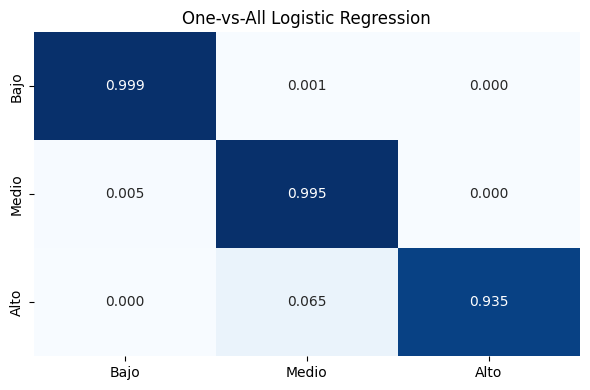

In [42]:
# Correr el modelo sin Feature Selection o Feature Extraction

# Definir Hiperparametros
alpha = 0.9
epochs = 10000

models_ova = one_vs_all_training(
        X_train, y_train,
        X_test, y_test,
        epochs, alpha
    )

y_pred_ova, probs_ova = predict_one_vs_all(X_test, models_ova)

# Analizar resultados
accuracy_ova = compute_accuracy(y_test, y_pred_ova)
print(f"\nAccuracy One-vs-All: {accuracy_ova:.2f}%")

analyze_results(y_test, y_pred_ova, "One-vs-All Logistic Regression")



--- Entrenando modelo Bajo vs Resto ---
Distribución Bajo: 5968/20000
20000
L_Train: 2.5741071101982387
L_Train: 0.11460548566664484
L_Train: 0.09042972861077919
L_Train: 0.07876299522771449
L_Train: 0.0714301350622952
L_Train: 0.06622576735375323
L_Train: 0.06226153496634685
L_Train: 0.05909854245027568
L_Train: 0.05649061094321277
L_Train: 0.054287057845028054
L_Train: 0.05238955440135976
L_Train: 0.05073070915037224
L_Train: 0.049262504642990444
L_Train: 0.04794963132964641
L_Train: 0.04676543681613482
L_Train: 0.04568935544474895
L_Train: 0.04470521697299091
L_Train: 0.04380009883089433
L_Train: 0.042963526286955496
L_Train: 0.042186902023219994
L_Train: 0.041463090969667826
L_Train: 0.040786112651695156
L_Train: 0.0401509095188261
L_Train: 0.039553169956887554
L_Train: 0.038989191305382385
L_Train: 0.03845577257841285
L_Train: 0.037950129539131475
L_Train: 0.03746982680443548
L_Train: 0.03701272307129746
L_Train: 0.036576926558520476
L_Train: 0.03616075847784239
L_Train: 0.035762

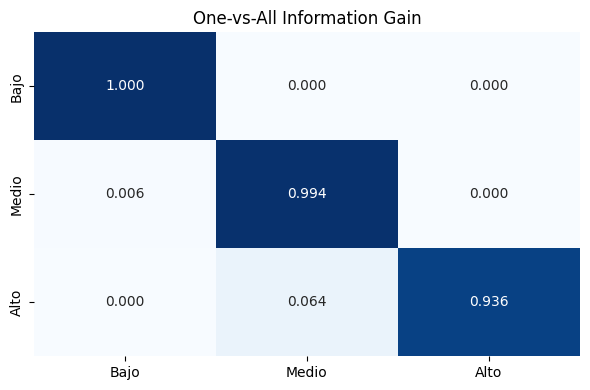


--- Entrenando modelo Bajo vs Resto ---
Distribución Bajo: 5968/20000
20000
L_Train: 2.3473471571853954
L_Train: 0.35055238236734687
L_Train: 0.35050185843534476
L_Train: 0.3505016044292157
L_Train: 0.3505016030848167
L_Train: 0.350501603077675
L_Train: 0.350501603077637
L_Train: 0.3505016030776369
L_Train: 0.3505016030776369
L_Train: 0.3505016030776369
L_Train: 0.35050160307763684
L_Train: 0.3505016030776369
L_Train: 0.3505016030776369
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train: 0.35050160307763684
L_Train

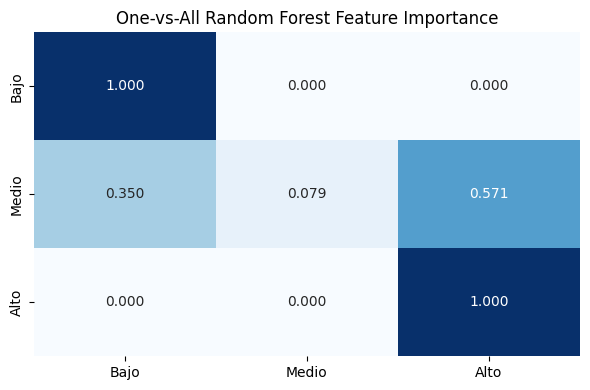


--- Entrenando modelo Bajo vs Resto ---
Distribución Bajo: 5968/20000
20000
L_Train: 2.5222042721328206
L_Train: 0.37186146190748237
L_Train: 0.37185140240214654
L_Train: 0.3718513823663263
L_Train: 0.3718513823254834
L_Train: 0.3718513823254001
L_Train: 0.3718513823253999
L_Train: 0.3718513823253999
L_Train: 0.3718513823253999
L_Train: 0.37185138232539994
L_Train: 0.3718513823253999
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_Train: 0.37185138232539994
L_T

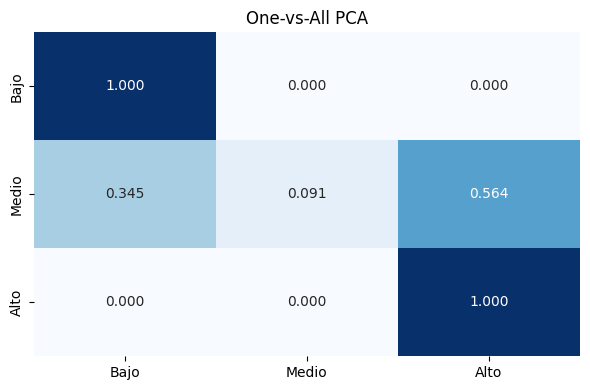

In [43]:
# Implementar reducción de dimensionalidad

def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_ig, X_test_ig, ig_indices = information_gain_selection(X_train, y_train, X_test, k=25)

models_ova = one_vs_all_training(
        X_train_ig, y_train,
        X_test_ig, y_test,
        epochs, alpha
    )

y_pred_ova, probs_ova = predict_one_vs_all(X_test_ig, models_ova)

# Analizar resultados
accuracy_ova = compute_accuracy(y_test, y_pred_ova)
print(f"\nAccuracy One-vs-All: {accuracy_ova:.2f}%")

analyze_results(y_test, y_pred_ova, "One-vs-All Information Gain")

def random_forest_feature_importance(X_train, y_train, X_test, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    top_k_indices = np.argsort(importances)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_rf, X_test_rf, rf_indices = random_forest_feature_importance(X_train, y_train, X_test, k=25)

models_ova = one_vs_all_training(
        X_train_rf, y_train,
        X_test_rf, y_test,
        epochs, alpha
    )

y_pred_ova, probs_ova = predict_one_vs_all(X_test_rf, models_ova)

# Analizar resultados
accuracy_ova = compute_accuracy(y_test, y_pred_ova)
print(f"\nAccuracy One-vs-All: {accuracy_ova:.2f}%")

analyze_results(y_test, y_pred_ova, "One-vs-All Random Forest Feature Importance")

def pca_dimensionality_reduction(X_train, X_test, n_components):

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return X_train_pca, X_test_pca, cumulative_variance

X_train_pca, X_test_pca, variance_explained = pca_dimensionality_reduction(X_train, X_test, n_components=30)

models_ova = one_vs_all_training(
        X_train_pca, y_train,
        X_test_pca, y_test,
        epochs, alpha
    )

y_pred_ova, probs_ova = predict_one_vs_all(X_test_pca, models_ova)

# Analizar resultados
accuracy_ova = compute_accuracy(y_test, y_pred_ova)
print(f"\nAccuracy One-vs-All: {accuracy_ova:.2f}%")

analyze_results(y_test, y_pred_ova, "One-vs-All PCA")